In [285]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.interpolate import interp1d
from sksurv.nonparametric import kaplan_meier_estimator
pd.set_option('display.max_columns', 500)
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick



%config InlineBackend.figure_formats = ['svg']

df = pd.read_csv('data/vv_capture_2025-07-23_14-12-58/cleaned_verifier_data.csv', converters={'FIPS code': str}).convert_dtypes()

# Non-VVSG equipment
non_voting_equipment = ['Paper Poll Book',
                        'Hand Counted Paper Ballots', 
                        'Commercial Electronic Poll Book',
                        'In-House Electronic Poll Book',
                        'Data Unavailable',
                        'Internet Voting: Email',
                        'Internet Voting: Web Portal',
                        'Internet Voting: Fax',
                        'Remote Ballot Marking System: Client-Side',
                        'Remote Ballot Marking System: Server-Side']

# VVSG equipment
voting_equipment = ['Ballot Marking Device', 
                    'Hand-Fed Optical Scanner',
                    'Batch-Fed Optical Scanner',
                    'DRE-Touchscreen',
                    'DRE-Push Button',
                    'DRE-Dial',
                    'Mechanical Lever Machine',
                    'Punch Card Voting System',
                    'Hybrid BMD/Tabulator',
                    'Hybrid Optical Scan/DRE',
                    'Hybrid Optical Scan/BMD']

modern_equipment = ['Ballot Marking Device', 
                    'Hand-Fed Optical Scanner',
                    'Batch-Fed Optical Scanner',
                    'DRE-Touchscreen',
                    'DRE-Push Button',
                    'DRE-Dial',
                    # 'Mechanical Lever Machine',
                    # 'Punch Card Voting System',
                    'Hybrid BMD/Tabulator',
                    'Hybrid Optical Scan/DRE',
                    'Hybrid Optical Scan/BMD'
                ]

# filter only for VVSG relevant equipment
df = df[df['Equipment Type'].isin(modern_equipment)]
df = df.dropna(subset=['Final Year in Use', 'Years in Use', 'Registered Voters', 'Equipment Type'])

# merge DRE categories
df.loc[df['Equipment Type'].str.startswith('DRE'), 'Equipment Type'] = 'DRE'


df26 = df[df['Year'] == 2026].copy()
retired = df[df['Final Year in Use']]

all = pd.concat([df26, retired])


/var/folders/2f/3k2b0y_s79n84y37bcnb5t5h0000gn/T/ipykernel_99291/2390741585.py:15: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/vv_capture_2025-07-23_14-12-58/cleaned_verifier_data.csv', converters={'FIPS code': str}).convert_dtypes()


In [286]:
df26['Equipment Type'].value_counts()

Equipment Type
Ballot Marking Device        5009
Hand-Fed Optical Scanner     4343
Batch-Fed Optical Scanner    1609
Hybrid Optical Scan/BMD       934
DRE                           413
Hybrid Optical Scan/DRE        77
Hybrid BMD/Tabulator           33
Name: count, dtype: Int64

In [287]:
len(df26)/(len(df26)+len(retired)) # % of rows with unknown retirement dates (i.e., are right-censored)

0.44542487176728

Text(0.5, 0, 'time $t$')

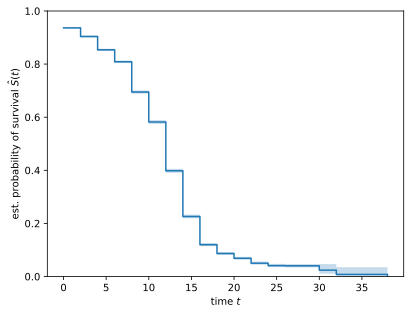

In [288]:
time, survival_prob, conf_int = kaplan_meier_estimator(
    all['Final Year in Use'], all['Years in Use'], conf_type="log-log"
)
plt.step(time, survival_prob, where="post")
plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
plt.ylim(0, 1)
plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")


In [289]:
# Create a function that returns survival probability at any t
survival_func = interp1d(time, survival_prob, kind="linear", bounds_error=False, fill_value=(1.0, 0.0))
survival_func

def hazard_func(t, survival_func, delta_time = 2):
    """
    Returns the hazard rate at time t; the probability of replacement at time t given survival until time t.
    """
    t = np.asarray(t)
    s_t = survival_func(t)
    s_t_plus = survival_func(t + delta_time)
    
    # Avoid division by zero by setting hazard to 0 where survival is 0
    with np.errstate(divide='ignore', invalid='ignore'):
        hazard = (s_t - s_t_plus) / s_t
        hazard = np.where(s_t == 0, 0.0, hazard)
    
    return hazard

hazard_func(range(0,40,2), survival_func, delta_time=2)

array([0.03472868, 0.05547195, 0.05274736, 0.14086902, 0.16251503,
       0.31563572, 0.43232158, 0.46975233, 0.27666667, 0.20792079,
       0.26900585, 0.1827957 , 0.01960784, 0.        , 0.4       ,
       0.66666667, 0.33333333, 0.5       , 1.        , 0.        ])

In [290]:
start_year = 2028 # first year that equipment starts being simulated for possible replacement
end_year = 2042
delta_time = 2
years = list(range(start_year, end_year + 1, delta_time))

simulation_df = df26.copy()
simulation_df["Simulated Replaced"] = False
simulation_df["Simulated Replace Year"] = None

for year in years:
    simulation_df["Simulated Years in Use"] = year - simulation_df["First Year in Use"]

    not_replaced_yet = simulation_df[~simulation_df["Simulated Replaced"]].copy()
    n = len(not_replaced_yet)

    hazard = hazard_func(not_replaced_yet['Simulated Years in Use'], survival_func, delta_time=delta_time)
    replaced = np.random.rand(n) < hazard
    replaced_idx = not_replaced_yet.loc[replaced].index
    simulation_df.loc[replaced_idx, "Simulated Replaced"] = True
    simulation_df.loc[replaced_idx, "Simulated Replace Year"] = year
    # simulation_df.loc[replaced_idx, "First Year in Use"] = year


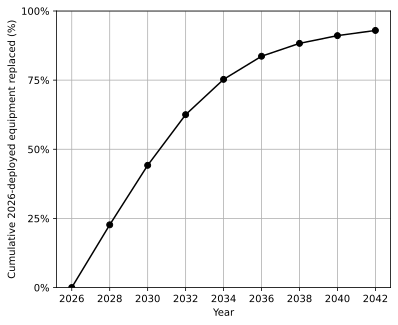

In [291]:
cumulative_replacement_proportion = simulation_df['Simulated Replace Year'].value_counts().sort_index().cumsum() / len(simulation_df)
cumulative_replacement_proportion[2026] = 0
cumulative_replacement_proportion.sort_index(inplace=True)

cumulative_replacement_proportion.plot(kind='line', figsize=(6, 5), marker='o', color='black', label='Overall')
plt.grid()
plt.ylabel('Cumulative 2026-deployed equipment replaced (%)')
plt.xlabel('Year')
plt.ylim(0, 1)
plt.yticks([0, 0.25, 0.5, 0.75, 1], ['0%', '25%', '50%', '75%', '100%']);

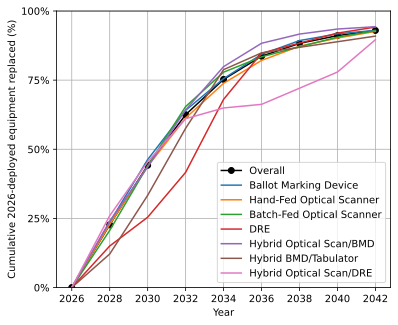

In [292]:
cumulative_replacement_proportion = simulation_df['Simulated Replace Year'].value_counts().sort_index().cumsum() / len(simulation_df)
cumulative_replacement_proportion[2026] = 0
cumulative_replacement_proportion.sort_index(inplace=True)
cumulative_replacement_proportion.plot(kind='line', figsize=(6, 5), marker='o', color='black', label='Overall')

equipment_types = simulation_df["Equipment Type"].unique()
for eq_type in equipment_types:
    eq_mask = simulation_df["Equipment Type"] == eq_type
    eq_df = simulation_df[eq_mask]
    cumulative_replacement_proportion = eq_df['Simulated Replace Year'].value_counts().sort_index().cumsum() / len(eq_df)
    cumulative_replacement_proportion[2026] = 0
    cumulative_replacement_proportion.sort_index(inplace=True)

    plt.plot(cumulative_replacement_proportion.index, cumulative_replacement_proportion, label=eq_type)
plt.legend()
plt.grid()
plt.ylabel('Cumulative 2026-deployed equipment replaced (%)')
plt.xlabel('Year')
plt.ylim(0, 1)
plt.yticks([0, 0.25, 0.5, 0.75, 1], ['0%', '25%', '50%', '75%', '100%']);

Project cost going forward. Variables to include:
- Cost of replacement equipment
    - `hand_fed_scanner_cost`
    - `batch_fed_scanner_cost`
    - `bmd_cost`
- Number of pieces of equipment required. Will be a function of the 'Precincts' (int) column and the 'Election Day Marking Method' (str) column
    - `n_hand_fed_scanners_per_precinct` # at least one
    - `n_bmds_per_precinct` # should be higher for 'Election Day Marking Method' in ['Ballot Marking Devices for all voters', 'DREs .* for all voters']
    - for jurisdictions that have batch-fed scanners, `n_batch_fed_scanners_per_voter`

- each row is a jurisdiction/equipment type combination. let's assume no sharing across jurisdictions.
- let's just assume that only jurisdictions that have batch scanners replace with other batch scanners
- let's assume that jurisdicitons with DREs replace them with BMDs. if they use DREs for all, they'll continue to use BMDs for all
- we will only do one replacement per jurisdiction
- no inflation yet, but maybe we add that later


In [293]:
df26['Equipment Type'].value_counts()

Equipment Type
Ballot Marking Device        5009
Hand-Fed Optical Scanner     4343
Batch-Fed Optical Scanner    1609
Hybrid Optical Scan/BMD       934
DRE                           413
Hybrid Optical Scan/DRE        77
Hybrid BMD/Tabulator           33
Name: count, dtype: Int64

- BMDs are usually paired with scanners, but not always? 4232 of 5009 BMD-having jurisdictions have scanners. ask megan how this can be. but close enough for now
- jurisdictions that have equipment starting with "Hybrid" usually don't have an associated scanner, so let's label them DREs, which will add in the scanner cost in our hacky way.


In [294]:
# Get FIPS codes for rows with 'Hybrid Optical Scan/BMD'
fips_hybrid = df26.loc[df26['Equipment Type'] == 'Hybrid BMD/Tabulator', 'FIPS code'].unique()

# Filter the full DataFrame to only rows with those FIPS codes
df26[df26['FIPS code'].isin(fips_hybrid)]['Equipment Type'].value_counts()


Equipment Type
Hybrid BMD/Tabulator         33
Batch-Fed Optical Scanner    31
Hand-Fed Optical Scanner      7
Name: count, dtype: Int64

In [295]:
# some DRE pre-processing 

# drop equipment that is used for curbside voting
curbside = simulation_df[simulation_df['Notes on usage'].str.contains('curbside', na=False)].index
simulation_df.drop(curbside, inplace=True)

# remove all DRE rows from jurisdictions that have both BMDs and DREs
bmd_and_dre = simulation_df.groupby(['FIPS code']).filter(lambda x: (x['Equipment Type'] == 'Ballot Marking Device').any() and (x['Equipment Type'] == 'DRE').any())

extra_dre = simulation_df[simulation_df['FIPS code'].isin(bmd_and_dre['FIPS code']) & (simulation_df['Equipment Type'] == 'DRE')].index
simulation_df.drop(extra_dre, inplace=True)

simulation_df.drop_duplicates(subset=['FIPS code', 'Equipment Type'], inplace=True, keep='first') # if a jurisdiction has multiple types of the same equipment, keep only the first one

# Hacky stuff below

# remove all hand-fed optical scanners from jurisdictions that have both DREs and hand-fed optical scanners
# because we're going to add those costs in a hacky way instead
dre_and_hand_fed = simulation_df.groupby(['FIPS code']).filter(lambda x: (x['Equipment Type'] == 'DRE').any() and (x['Equipment Type'] == 'Hand-Fed Optical Scanner').any())
extra_hand_fed = simulation_df[simulation_df['FIPS code'].isin(dre_and_hand_fed['FIPS code']) & (simulation_df['Equipment Type'] == 'Hand-Fed Optical Scanner')].index
simulation_df.drop(extra_hand_fed, inplace=True)

# Call all equipment types starting with Hybrid DREs
simulation_df.loc[simulation_df['Equipment Type'].str.startswith('Hybrid'), 'Equipment Type'] = 'DRE'

simulation_df.drop_duplicates(subset=['FIPS code', 'Equipment Type'], inplace=True, keep='first') # if a jurisdiction has multiple types of the same equipment, keep only the first one


In [296]:
def estimate_cost(row, params):
    equipment = row["Equipment Type"]
    method = row["Election Day Marking Method"]
    precincts = row["Precincts"]
    voters = row["Registered Voters"]

    cost = 0
    
    if method in bmds_dres_for_all:
        if equipment == 'Ballot Marking Device':
            cost = np.ceil(params["n_bmds_for_all_per_precinct"] * precincts) * params["bmd_cost"]
        elif equipment == 'DRE':
            cost =  np.ceil(params["n_bmds_for_all_per_precinct"] * precincts) * params["bmd_cost"] + \
                    np.ceil(params["n_hand_fed_scanners_per_precinct"] * precincts) * params["hand_fed_scanner_cost"]
                    # because we've already removed scanners for the DRE for all jurisdictions
    else:
        if equipment in ['Ballot Marking Device', 'DRE']:
            cost = np.ceil(params["n_bmds_per_precinct"] * precincts) * params["bmd_cost"]
        elif equipment == 'Hand-Fed Optical Scanner':
            cost = np.ceil(params["n_hand_fed_scanners_per_precinct"] * precincts) * params["hand_fed_scanner_cost"]
        elif equipment == 'Batch-Fed Optical Scanner':
            cost = np.ceil(voters / params["n_voters_per_batch_scanner"]) * params["batch_fed_scanner_cost"]

    return cost * params["vvsg2_multiplier"]

bmds_dres_for_all = ['Ballot Marking Devices for all voters', 'DREs with VVPAT for all voters', 'DREs without VVPAT for all voters']

# Custom formatter: shows M or B with 1 decimal when needed
def money_formatter(x, pos):
    abs_x = abs(x)
    
    if abs_x >= 1e12:
        return f'${x / 1e12:.3f}T'.rstrip('0').rstrip('.')
    elif abs_x >= 1e9:
        return f'${x / 1e9:.3g}B'.rstrip('0').rstrip('.')
    elif abs_x >= 1e6:
        return f'${x / 1e6:.3g}M'.rstrip('0').rstrip('.')
    elif abs_x >= 1e3:
        return f'${x / 1e3:.3g}K'
    else:
        return f'${x:.0f}'


In [ ]:
# Simulation parameters:
# - vvsg2_multiplier: applies a cost bump to all equipment types to reflect VVSG 2.x
#       ACET says 20-50% more, but we've heard lower and higher estimates, so let's use 1.2.
# - bmd_cost: base cost of Ballot Marking Devices. $3500 is what Brennan used,
#       and aligns with Caulfield's findings for ExpressVote pricing.
# - hand_fed_scanner_cost: cost of precinct-count scanners like DS200.
#       $5750 replicates Caulfield's estimate for DS200:
#       "We present summary statistics on pricing trends for a number of different voting
#        machines. The most common one in our sample—ES&S’s Model DS200 optical
#        scanner—had a strikingly consistent mode and median unit price of $5,750, which
#        is consistent with previous assessments"
#       $5000 is what Brennan used
# - batch_fed_scanner_cost: cost of high-speed scanners like DS850.
#       "These scan­ners can cost anywhere between $50,000 and $100,000 each,"
#       according to https://verifiedvoting.org/voting-machines-at-risk-in-2022-a-joint-analysis-from-the-brennan-center-and-verified-voting/
# - n_hand_fed_scanners_per_precinct: number of hand-fed scanners per precinct.
# - n_bmds_per_precinct: number of BMDs per precinct.
# - n_bmds_for_all_per_precinct: number of BMDs per precinct in jurisdictions
#       that use BMDs or DREs for all voters.
# - n_voters_per_batch_scanner: number of voters required per batch-fed scanner.
#   could get some anchors and adjust this by rate of mail-in voting.

parameters = {
    "vvsg2_multiplier": 1.2,
    "bmd_cost": 3500,
    "hand_fed_scanner_cost": 5000,
    "batch_fed_scanner_cost": 75000,
    "n_hand_fed_scanners_per_precinct": 1,
    "n_bmds_per_precinct": 0.65, # more realistic numbers are if you use N polling places in EAVS. but because this is what's in the VV data, we'll use this and it should be a good enough match. raise this with megan
    "n_bmds_for_all_per_precinct": 3.55,
    "n_voters_per_batch_scanner": 10000,
}


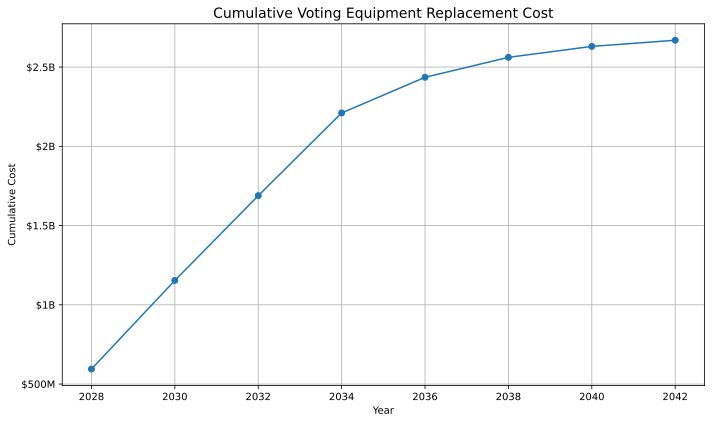

In [320]:
# Filter to only replaced equipment
replaced_df = simulation_df[simulation_df["Simulated Replaced"]].copy()

# do this filter to replicate brennan footnote 3
# replaced_df = replaced_df[(replaced_df['Equipment Type']=='DRE') & (replaced_df['Election Day Marking Method']== 'DREs without VVPAT for all voters')]

# do this filter to replicate brennan footnote 4
# replaced_df = replaced_df[(replaced_df['Election Day Standard'] | replaced_df['Election Day Accessible']) & (replaced_df['First Year in Use'] <= 2014)]


replaced_df["Estimated Cost"] = replaced_df.apply(lambda x:
                                                  estimate_cost(x, parameters),
                                                  axis=1)

# replaced_df['Simulated Replace Year'] = 2030
# Aggregate cost by year
cost_by_year = replaced_df.groupby("Simulated Replace Year")["Estimated Cost"].sum().reset_index()
cost_by_year.columns = ["Year", "Total Replacement Cost"]

# Add cumulative cost column
cost_by_year["Cumulative Cost"] = cost_by_year["Total Replacement Cost"].cumsum()

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(cost_by_year["Year"], cost_by_year["Cumulative Cost"], marker='o')
    
ax.yaxis.set_major_formatter(mtick.FuncFormatter(money_formatter))

# Labels and title
ax.set_title("Cumulative Voting Equipment Replacement Cost", fontsize=14)
ax.set_xlabel("Year")
ax.set_ylabel("Cumulative Cost")
ax.grid(True)

plt.tight_layout()
plt.show()

# Center for Secure and Modern Elec­tions has estim­ated that the full cost of repla­cing outdated voting machines over the next decade will amount to $1.8 billion.


### Is equipment type or jurisdiction size predictive of replacement? No
Analysis below. It justifies doing just the simple fitting procedure that we do above.

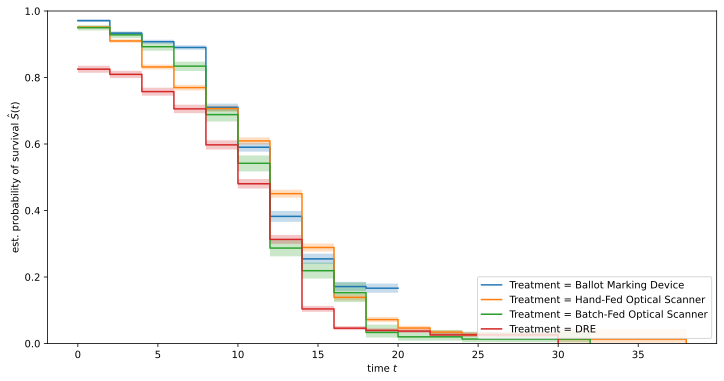

In [656]:
plt.figure(figsize=(12, 6))
for treatment_type in (all['Equipment Type'].unique()):
    mask_treat = all["Equipment Type"] == treatment_type
    time_treatment, survival_prob_treatment, conf_int = kaplan_meier_estimator(
        all["Final Year in Use"][mask_treat],
        all["Years in Use"][mask_treat],
        conf_type="log-log",
    )

    plt.step(time_treatment, survival_prob_treatment, where="post", label=f"Treatment = {treatment_type}")
    plt.fill_between(time_treatment, conf_int[0], conf_int[1], alpha=0.25, step="post")
plt.ylim(0, 1)
plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="lower right")


In [ ]:
from sklearn import set_config
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
from sksurv.preprocessing import OneHotEncoder



set_config(display="text")  # displays text representation of estimators

all['Equipment Type'] = all['Equipment Type'].astype('category')
data_x = all[['Registered Voters']]

data_y = np.array(
    list(zip(all["Final Year in Use"].astype(bool), all["Years in Use"].astype(float))),
    dtype=[("Status", "?"), ("Survival_in_years", "<f8")]
)

estimator = CoxPHSurvivalAnalysis()
estimator.fit(data_x, data_y)


prediction = estimator.predict(data_x)
result = concordance_index_censored(data_y["Status"], data_y["Survival_in_years"], prediction)
f"{result[0]:.5f}"

# registered voters is not predictive on its own.

'0.48804'

In [ ]:
set_config(display="text")  # displays text representation of estimators

all['Equipment Type'] = all['Equipment Type'].astype('category')
data_x = OneHotEncoder().fit_transform(all[['Equipment Type']])

data_y = np.array(
    list(zip(all["Final Year in Use"].astype(bool), all["Years in Use"].astype(float))),
    dtype=[("Status", "?"), ("Survival_in_years", "<f8")]
)

estimator = CoxPHSurvivalAnalysis()
estimator.fit(data_x, data_y)


prediction = estimator.predict(data_x)
result = concordance_index_censored(data_y["Status"], data_y["Survival_in_years"], prediction)
f"{result[0]:.5f}"

'0.56392'

In [661]:
set_config(display="text")  # displays text representation of estimators

all['Equipment Type'] = all['Equipment Type'].astype('category')
data_x = OneHotEncoder().fit_transform(all[['Equipment Type', 'Registered Voters']])

data_y = np.array(
    list(zip(all["Final Year in Use"].astype(bool), all["Years in Use"].astype(float))),
    dtype=[("Status", "?"), ("Survival_in_years", "<f8")]
)

estimator = CoxPHSurvivalAnalysis()
estimator.fit(data_x, data_y)


prediction = estimator.predict(data_x)
result = concordance_index_censored(data_y["Status"], data_y["Survival_in_years"], prediction)
f"{result[0]:.5f}"

'0.56148'

In [662]:

def fit_and_score_features(X, y):
    n_features = X.shape[1]
    scores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis()
    for j in range(n_features):
        Xj = X[:, j : j + 1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
    return scores


scores = fit_and_score_features(data_x.values, data_y)
pd.Series(scores, index=data_x.columns).sort_values(ascending=False)

Equipment Type=DRE                          0.548951
Equipment Type=Hand-Fed Optical Scanner     0.509099
Equipment Type=Batch-Fed Optical Scanner    0.497047
Registered Voters                           0.488040
dtype: float64

The above numbers are pretty low. 0.5 is a random model.